# Kickstarter Projects
This is a Notebook to work the kickstarter_projects kaggle dataset. We're about to see how bla bla...

database link: https://www.kaggle.com/datasets/kemical/kickstarter-projects

### Imports

In [29]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import *
from sklearn import svm,datasets,tree,neighbors,metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

import category_encoders as ce
import matplotlib.pyplot as plt

Usaremos el segundo dataset puesto que ambos tienen algunos atributos diferentes, ambos tienen instancias en común costosas de filtrar, ambos tienen más de 300000 instancias (información más que suficiente) y el segundo tiene los atributos monetarios ya convertidos a USD.

Atributos iniciales : ID, name, category, main_category, currency, deadline, goal, launched, pledged, state, backers, country, usd pledged

In [2]:
#Load datasets
#df1 = pd.read_csv('../data/ks-projects-201612.csv', encoding = 'utf-8', encoding_errors = 'replace')
#df2 = pd.read_csv('../data/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')
df = pd.read_csv('../data/ks-projects-201801.csv', encoding = 'cp1252', encoding_errors = 'replace')

In [3]:
# Podemos ver atributos que no nos dicen nada como ID, name
# Observamos que hay atributos repetidos como  goal, pledged y usd pledged
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Tratamiento de NaNs
Hemos tenido suerte al no tener NaNs

In [4]:
df = df.drop(columns=['ID', 'name', 'usd pledged', 'pledged', 'goal'])
print(df.isnull().sum(axis = 0))
#print((df == '?').sum(axis=0))

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
dtype: int64


### Nuevos atributos
Definamos dos nuevos atributos y reordenemos de forma que el atributo objetivo sea el último

In [5]:
# definimos nuevos atributos
df['elapsed_days'] = (pd.to_datetime(df['deadline'])-pd.to_datetime(df['launched'])).dt.total_seconds()/(3600*24)
df['deadline'] = (pd.to_datetime(df['deadline']) - dt.datetime(2009,1,1)).dt.total_seconds()
df['launched'] = (pd.to_datetime(df['launched']) - dt.datetime(2009,1,1)).dt.total_seconds()
#df = df.drop(columns=['launched', 'deadline'])

df['pledged/backer'] = df['usd_pledged_real']/df['backers']
df['pledged/backer'].fillna(value = 0, inplace=True)
a = np.max(df['pledged/backer'])
df.loc[df["pledged/backer"] == a, "pledged/backer"] = 0

col_list = list(df.columns)
x, y = col_list.index(df.columns[-1]), col_list.index('state')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

col_list = list(df.columns)
x, y = col_list.index('pledged/backer'), col_list.index('country')
col_list[y], col_list[x] = col_list[x], col_list[y]
df = df[col_list]

### Atributo objetivo
Podemos ver que el atributo objetivo tiene seis posibles valores, de los cuales _failed_ y _successful_ son los más frecuentes.

In [6]:
values = df['state'].to_numpy()
values, cont = np.unique(values, return_counts = True)
print(values)
print(cont)
#should we drop live all except failed and successful?
print('Successful y failed representan el ', round((cont[1] + cont[3])*100/cont.sum()), '% del dataset')

['canceled' 'failed' 'live' 'successful' 'suspended' 'undefined']
[ 38779 197719   2799 133956   1846   3562]
Successful y failed representan el  88 % del dataset


Eliminamos las entradas que no sean de estos dos tipos mayoritarios. A _failed_ le asignaremos un 0 y a _successful_ un 1.

In [7]:
# nos quedamos solo con los registros fallidos o logrados (~88%)
df = df[np.logical_or(df['state'] == 'failed',df['state'] == 'successful')]
df.loc[df["state"] == "failed", "state"] = 0
df.loc[df["state"] == "successful", "state"] = 1

### Atributos categóricos
Ahora veremos cuántos y qué valores toman los atributos categóricos

In [8]:
#23 paises distintos
aux = df['country'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['AT' 'AU' 'BE' 'CA' 'CH' 'DE' 'DK' 'ES' 'FR' 'GB' 'HK' 'IE' 'IT' 'JP'
 'LU' 'MX' 'N,0"' 'NL' 'NO' 'NZ' 'SE' 'SG' 'US']
[   485   6616    523  12370    652   3436    926   1873   2520  29454
    477    683   2369     23     57   1411    210   2411    582   1274
   1509    454 261360]
(23,)


In [9]:
#15 categorias principales
aux = df['main_category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['Art' 'Comics' 'Crafts' 'Dance' 'Design' 'Fashion' 'Film & Video' 'Food'
 'Games' 'Journalism' 'Music' 'Photography' 'Publishing' 'Technology'
 'Theater']
[25641  9878  7818  3573 25364 19775 56527 22054 28521  4149 45949  9689
 35445 27050 10242]
(15,)


In [10]:
#159 categorias
aux = df['category'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin' 'Letterpress'

In [11]:
#159 categorias
aux = df['currency'].to_numpy()
aux, auxn = np.unique(aux, return_counts = True)
print(aux)
print(auxn)
print(aux.shape)

['AUD' 'CAD' 'CHF' 'DKK' 'EUR' 'GBP' 'HKD' 'JPY' 'MXN' 'NOK' 'NZD' 'SEK'
 'SGD' 'USD']
[  6621  12375    652    929  14378  29476    477     23   1411    584
   1274   1510    454 261511]
(14,)


In [12]:
attributes = df.columns
for i in range(len(attributes)):
    print(i, attributes[i])

0 category
1 main_category
2 currency
3 deadline
4 launched
5 country
6 backers
7 pledged/backer
8 usd_pledged_real
9 usd_goal_real
10 elapsed_days
11 state


### Filtrado de valores singulares (_Outliers_)
Filtraremos de forma intuitiva las entradas que contengan valores que no nos interesan, como por ejemplo proyectos que recaudaban menos de 10 USD o más de 100000 USD.

In [13]:
df1 = df[df['backers'] <= 2000]
df1 = df1[df1['usd_goal_real'] <= 100000]
df1 = df1[df1['usd_goal_real'] >= 10]
df1 = df1[df1['pledged/backer'] <= 10000]
#df1 = df1[df1['pledged/backer'] > 0] #uncomment to see gamma distribution plot of pledged/backer
df = df1

### Plots
Vemos algunos gráficos para entender la distribución de los datos

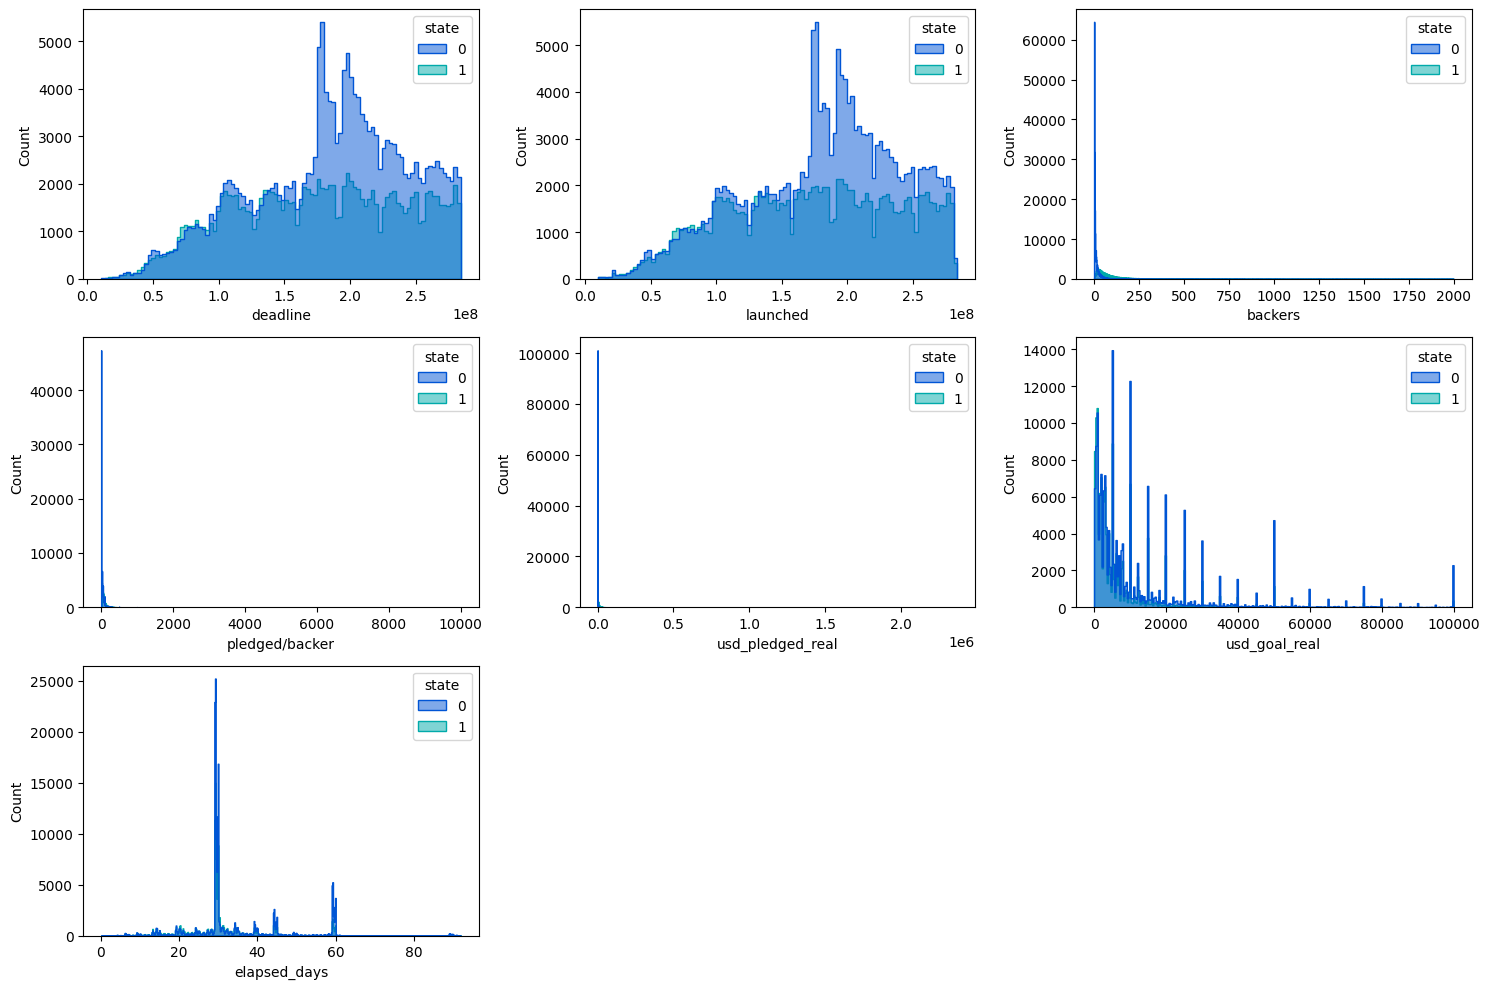

In [14]:
# distribució dels atributs segons els dos valors de l'state
plt.figure(figsize = (15,10), tight_layout = True)

for i, feature in enumerate(df.columns[[3,4,6,7,8,9,10]]):
    plt.subplot(3,3,i+1)
    sns.histplot(data = df1, x =feature, palette='winter', hue = 'state',alpha = 0.5, element="step" )

C:\Users\javie\AppData\Local\Temp\ipykernel_27284\3108248877.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), ax = ax, annot = True)


<AxesSubplot: >

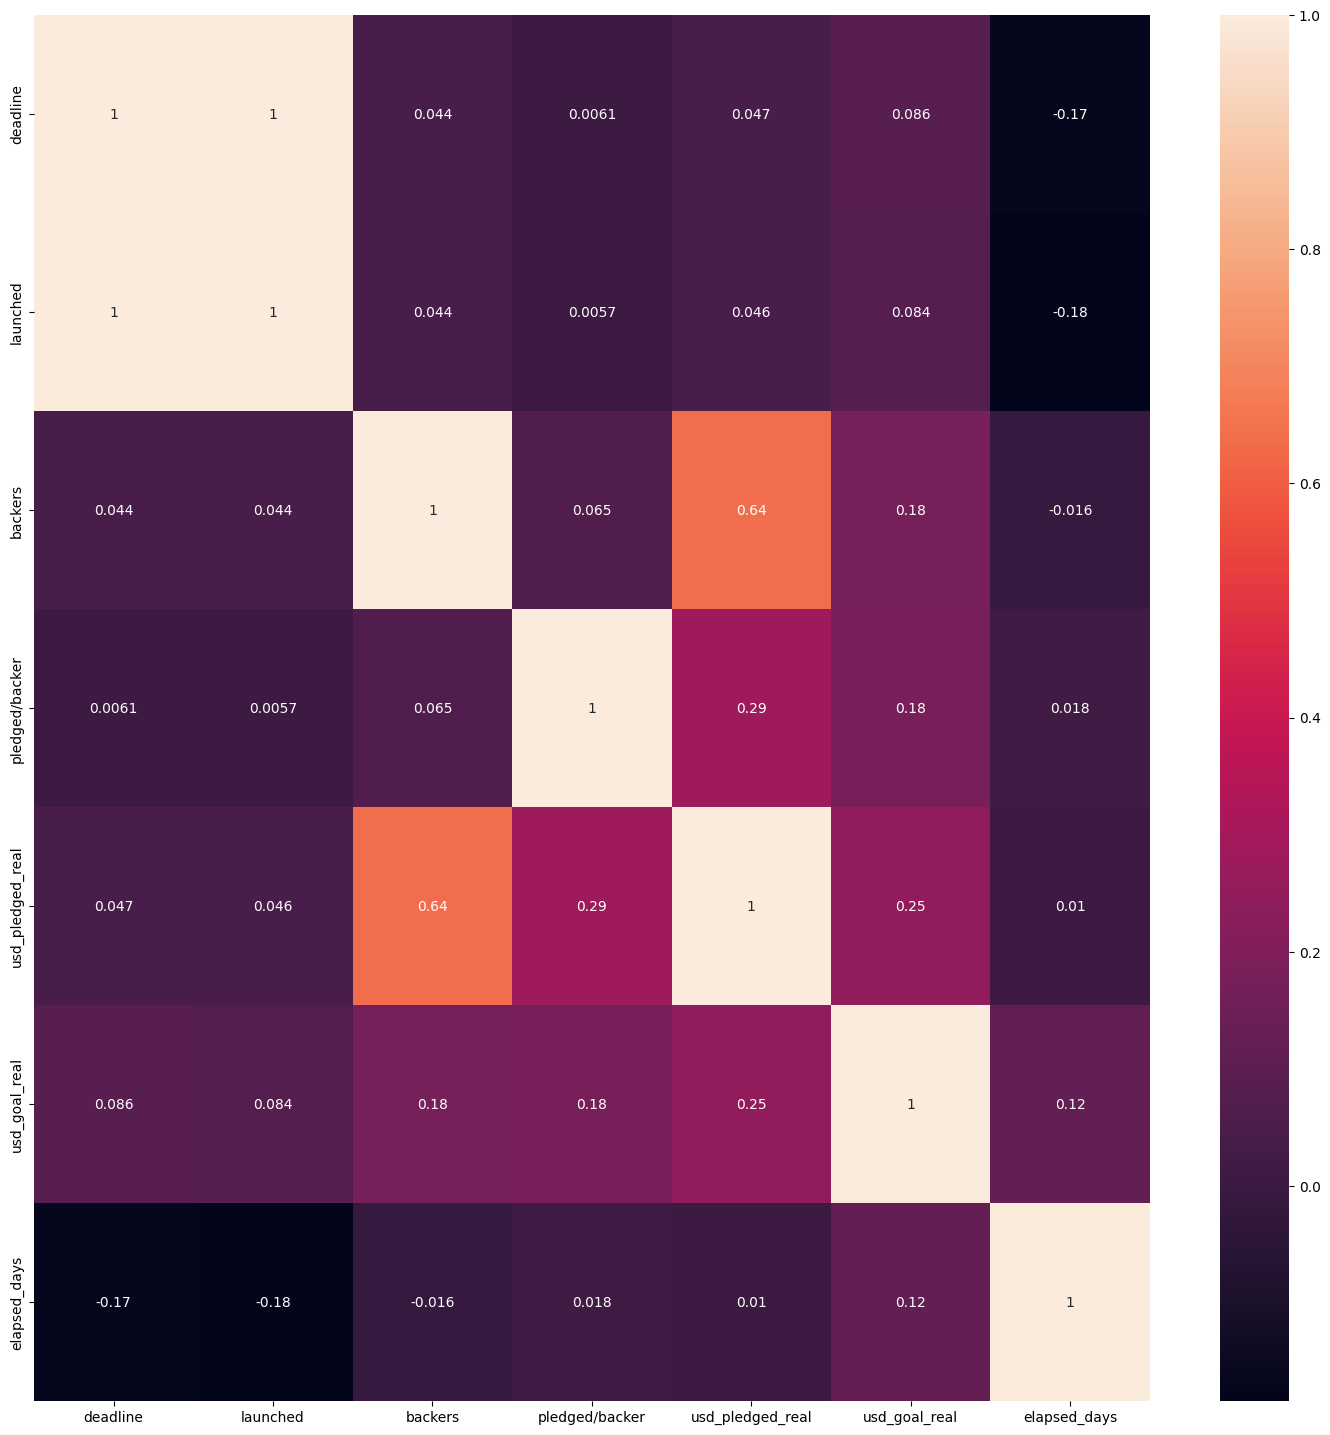

In [15]:
fig, ax = plt.subplots(figsize = (18,18))
sns.heatmap(df.corr(), ax = ax, annot = True)

### Atributos que usaremos
Hemos visito cómo se distribuyen los atributos, pero no los vamos a usar todos. De ser así, tendríamos un model que prácticamente sería infalible. Nos quedaremos únicamente con los atributos que sepamos _a priori_ del lanzamiento de un nuevo proyecto.

In [16]:
df = df.drop(columns=['backers', 'pledged/backer', 'usd_pledged_real', 'elapsed_days', 'deadline'])

In [17]:
attributes = df.columns
for i in range(len(attributes)):
    print(i, attributes[i])

0 category
1 main_category
2 currency
3 launched
4 country
5 usd_goal_real
6 state


### Codificación de los atributos categóricos
Para codificar los atributos categóricos usaremos o bien _binary encoding_ o bien _One-Hot encoding_.

In [18]:
codification = 'one-hot'

if(codification == 'one-hot'):
    ce_OHE = ce.OneHotEncoder(cols=df.columns[[0,1,2,4]])
    dff = ce_OHE.fit_transform(df)
elif(codification == 'binary'):
    ce_be = ce.BinaryEncoder(cols=df.columns[[0,1,2,4]])
    dff = ce_be.fit_transform(df);
dff

C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems i

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,country_16,country_17,country_18,country_19,country_20,country_21,country_22,country_23,usd_goal_real,state
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1533.95,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30000.00,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,45000.00,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5000.00,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50000.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6500.00,0
378657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1500.00,0
378658,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15000.00,0
378659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15000.00,0


### Normalización de los datos
Normalizamos los datos :)

In [19]:
mm = MinMaxScaler()
mm_data = mm.fit_transform(dff)
mm_data

array([[1.        , 0.        , 0.        , ..., 0.        , 0.01524102,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.29992999,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.44994499,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.14991499,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14991499,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01990199,
        0.        ]])

## Train/Test
Aquí separaremos el dataset en train y test en una proporción 70 train/30 test

In [20]:
X = mm_data[:, :-1]
y = mm_data[:,-1].astype(int)
x_t, x_v, y_t, y_v = train_test_split(X, y, test_size = 0.3, random_state = 42)
resultados = {}

## Clasificador KNN
Aqui implementamos el modelo KNN con valores de K a escoger. Además podremos ver las métricas, la matriz de confusión y la curva ROC.

KNN amb k 5
f1 score: 0.5338147776663323
accuracy: 0.6359183247166954
recall: 0.5097177882773593
precision: 0.5603032004491858


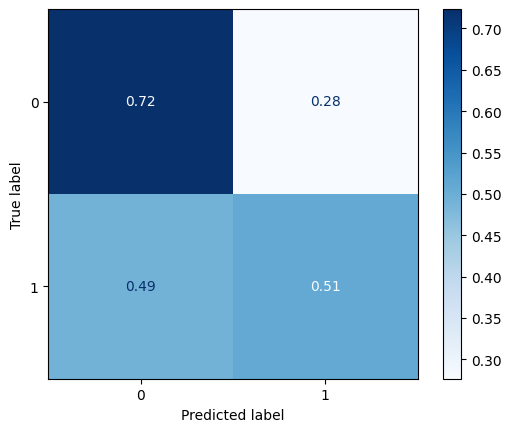

KNN amb k 15
f1 score: 0.5482236290976008
accuracy: 0.6564102564102564
recall: 0.5097688673221811
precision: 0.5929534787000178


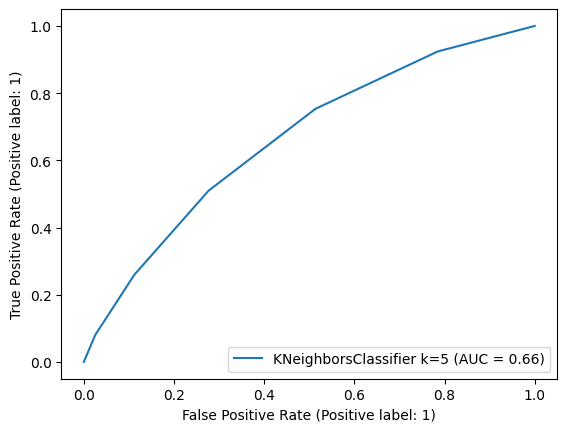

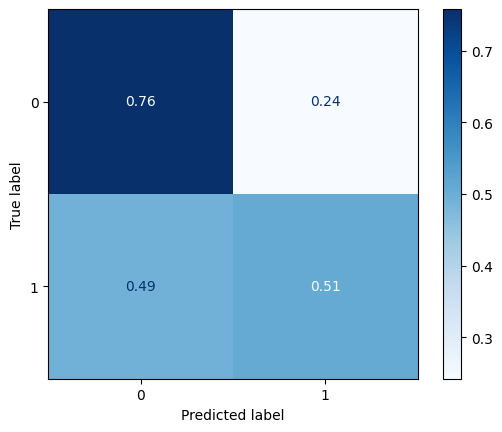

KNN amb k 50
f1 score: 0.542417670798087
accuracy: 0.6672306647866729
recall: 0.4822883412080194
precision: 0.6196757891973486


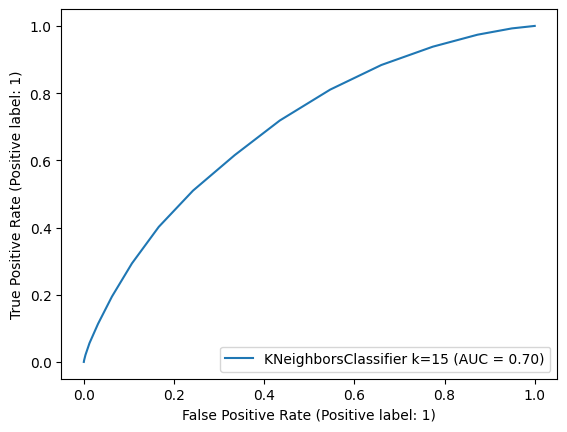

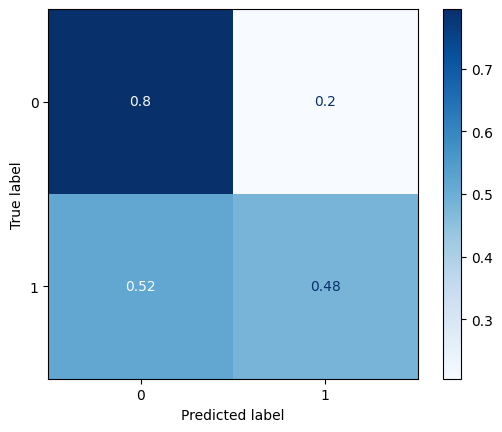

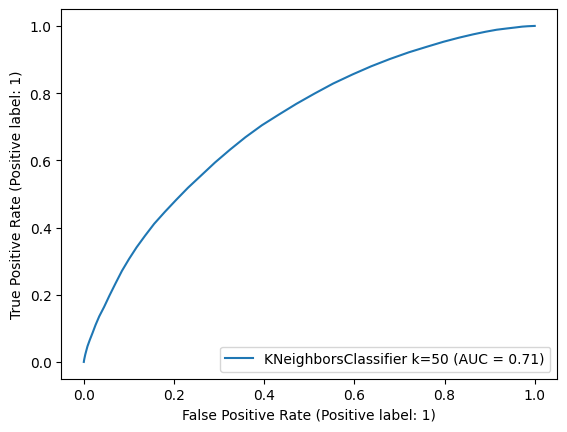

In [21]:
kvalues = [5,15,50]
for i in kvalues:
    knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform')
    knn.fit(x_t, y_t)
    preds = knn.predict(x_v)
    d = {}
    # prints
    print('KNN amb k ' + str(i))
    d['f1 score'] = f1_score(y_v, preds)
    d['accuracy'] = accuracy_score(y_v, preds)
    d['recall'] = recall_score(y_v, preds)
    d['precision'] = precision_score(y_v, preds)
    print('f1 score: ' + str(d['f1 score']))
    print('accuracy: ' + str(d['accuracy']))
    print('recall: ' + str(d['recall']))
    print('precision: ' + str(d['precision']))
    #confusion matrix
    cm = metrics.confusion_matrix(y_v, preds, normalize = 'true')
    d['confusion matrix'] = cm
    resultados['knn k=' + str(i)] = d
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues)
    plt.show()
    RocCurveDisplay.from_estimator(knn, x_v, y_v, name = 'KNeighborsClassifier k=' + str(i))
    #print(d)

### Cross Validation
Primero definimos una función para poder cross-validar los resultados dado un modelo, un dataset y un número de particiones.

In [22]:
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

Vamos a probar la función con el KNN

In [23]:
model = KNeighborsClassifier(n_neighbors=5, weights = 'uniform')
metrics_cv = cross_validation(model, x_t, y_t, _cv=5)

In [24]:
for i in metrics_cv.keys():
    print(i, metrics_cv[i])

Training Accuracy scores [0.75508331 0.75501058 0.75483712 0.75387611 0.75328861]
Mean Training Accuracy 75.44191457518173
Training Precision scores [0.72069743 0.72064948 0.71961413 0.71909808 0.71825969]
Mean Training Precision 0.719663762556187
Training Recall scores [0.6555826  0.65539118 0.65684049 0.65406965 0.65345438]
Mean Training Recall 0.6550676597007585
Training F1 scores [0.68659965 0.6864729  0.68679591 0.68504411 0.68432621]
Mean Training F1 Score 0.6858477535515896
Validation Accuracy scores [0.6308498  0.63355789 0.63651216 0.63460161 0.64095792]
Mean Validation Accuracy 63.52958777087999
Validation Precision scores [0.55392304 0.55745883 0.56135927 0.55829463 0.56779149]
Mean Validation Precision 0.5597654515793519
Validation Recall scores [0.50308996 0.50724638 0.5113481  0.51279807 0.51350908]
Mean Validation Recall 0.5095983189188275
Validation F1 scores [0.52728419 0.53116857 0.53518789 0.53458008 0.53928777]
Mean Validation F1 Score 0.5335016989125073


## Regresión logística
Aquí aplicaremos el modelo de regresión logística

C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1 score: 0.5410474068642658
accuracy: 0.6600553553710377
recall: 0.4899757374537096
precision: 0.6040046595094922


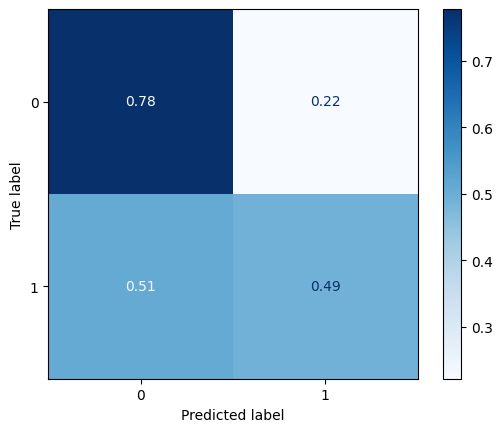

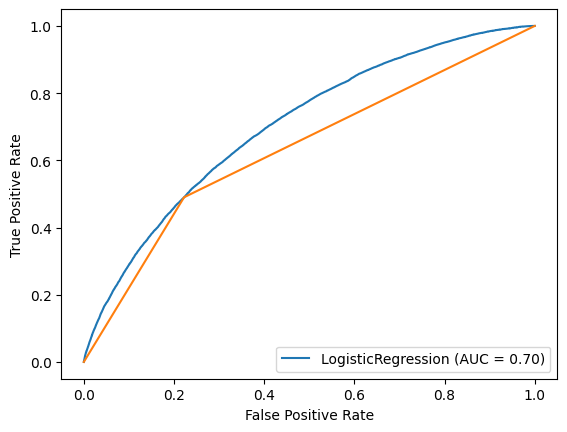

In [30]:
model = LogisticRegression(C=0.5)
model.fit(x_t, y_t)
preds = model.predict(x_v)
d = {}
# metricas
d['model'] = 'logistic regression'
d['f1 score'] = f1_score(y_v, preds)
print('f1 score: ' + str(d['f1 score']))
d['accuracy'] = accuracy_score(y_v, preds)
print('accuracy: ' + str(d['accuracy']))
d['recall'] = recall_score(y_v, preds)
print('recall: ' + str(d['recall']))
d['precision'] = precision_score(y_v, preds)
print('precision: ' + str(d['precision']))
#confusion matrix
cm = metrics.confusion_matrix(y_v, preds, normalize = 'true')
d['confusion matrix'] = cm
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

#define metrics
fpr, tpr, _ = metrics.roc_curve(y_v,  preds)
RocCurveDisplay.from_estimator(model, x_v, y_v)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Cross Validation
De nuevo cross-validamos los resultados para este modelo

In [31]:
model = LogisticRegression(C=0.5)
metrics_cv = cross_validation(model, x_t, y_t, _cv=5)

C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\javie\Desktop\UAB\Informática\Tercero\Aprenentatge Computacional\apc_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

In [32]:
for i in metrics_cv.keys():
    print(i, metrics_cv[i])

Training Accuracy scores [0.66060138 0.66179877 0.66123365 0.66086066 0.66097816]
Mean Training Accuracy 66.10945246373439
Training Precision scores [0.60553019 0.60779185 0.60728586 0.60634667 0.60624534]
Mean Training Precision 0.6066399842958434
Training Recall scores [0.48955399 0.48932156 0.48731166 0.48827575 0.48947894]
Mean Training Recall 0.4887883788053097
Training F1 scores [0.54140079 0.54216028 0.54072383 0.54094338 0.54164051]
Mean Training F1 Score 0.5413737565244253
Validation Accuracy scores [0.65978828 0.65768447 0.66010161 0.66060877 0.66304834]
Mean Validation Accuracy 66.02462955489683
Validation Precision scores [0.60376851 0.60139718 0.60574823 0.60502222 0.61055947]
Mean Validation Precision 0.6052991199804387
Validation Recall scores [0.49067542 0.48493301 0.48526114 0.49152264 0.48763947]
Mean Validation Recall 0.48800633483302097
Validation F1 scores [0.54137879 0.5369221  0.53885161 0.54239845 0.54222033]
Mean Validation F1 Score 0.5403542563807141
